# swin

> Swin Transformer V2 Encoder for midi-rae — drop-in replacement for ViTEncoder

In [ ]:
#| default_exp swin

In [ ]:
#| hide
from nbdev.showdoc import *

## Design Overview

### What this module does

`SwinEncoder` is a drop-in replacement for `ViTEncoder` that uses the **Swin Transformer V2**
architecture. It takes a piano roll image `(B, 1, 128, 128)` and returns an `EncoderOutput`
with hierarchical multi-scale patch states.

### Why Swin V2?

- **Hierarchical representation**: 7 levels from finest (64×64 grid, dim=4) down to a single
  CLS-like token (1×1, dim=256), compared to ViT's flat single-scale output
- **Efficient attention**: Windowed attention with shifted windows — O(N) instead of O(N²)
- **V2 improvements**: Cosine attention with learned log-scale temperature, continuous position
  bias via CPB MLP, res-post-norm for training stability

### Architecture

| Stage | Grid | Patch covers | Dim | Depths | Heads |
|-------|------|-------------|-----|--------|-------|
| 0 | 64×64 | 2×2 | 4 | 1 | 1 |
| 1 | 32×32 | 4×4 | 8 | 1 | 1 |
| 2 | 16×16 | 8×8 | 16 | 2 | 1 |
| 3 | 8×8 | 16×16 | 32 | 2 | 2 |
| 4 | 4×4 | 32×32 | 64 | 6 | 4 |
| 5 | 2×2 | 64×64 | 128 | 2 | 8 |
| 6 | 1×1 | 128×128 | 256 | 1 | 16 |

Config is in `configs/config_swin.yaml`.

### Implementation approach

We use **timm's `SwinTransformerV2Stage` directly** — no copied or modified Swin internals.
Our `SwinEncoder` wrapper handles only:

1. **Patch embedding** — `Conv2d(1, 4, kernel_size=2, stride=2)` + LayerNorm
2. **Empty patch detection** — patches where all pixels are black get a learnable `empty_token`
3. **MAE masking** (SimMIM-style) — masked patches get a learnable `mask_token`, grid stays
   intact so windowed attention works unmodified. Two-rate sampling: non-empty patches masked
   at `mask_ratio`, empty patches at `mask_ratio × empty_mask_ratio` (default 5%)
4. **Hierarchical output** — collects each stage's output into `HierarchicalPatchState`
   (coarsest-first), packaged as `EncoderOutput`

### Key differences from ViTEncoder

- No CLS token (stage 6's single 1×1 token serves as a global summary)
- No RoPE (Swin V2 uses its own continuous position bias)
- MAE masking keeps all tokens (SimMIM-style) — no compute savings but preserves spatial grid
- `empty_mask_ratio` controls how often trivial-to-reconstruct empty patches are masked

### TODOs

- `HierarchicalPatchState` could store `window_size` per level
- `EncoderOutput` could store scale metadata (downsample factors per level)

In [ ]:
#| export
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Optional, Tuple, Set, Type, Union
from functools import partial

from timm.models.swin_transformer_v2 import SwinTransformerV2Stage
from timm.layers import trunc_normal_, to_2tuple, calculate_drop_path_rates
from midi_rae.core import PatchState, HierarchicalPatchState, EncoderOutput

In [ ]:
#| export
#| export
class SwinEncoder(nn.Module):
    "Swin Transformer V2 Encoder for midi-rae — drop-in replacement for ViTEncoder.  (Wrapper for timm routines)"
    def __init__(self,
                 img_height:int,           # Input image height in pixels (e.g. 128)
                 img_width:int,            # Input image width in pixels (e.g. 128)
                 patch_h:int=2,            # Patch height for initial embedding
                 patch_w:int=2,            # Patch width for initial embedding
                 in_chans:int=1,           # Number of input channels (1 for piano roll)
                 embed_dim:int=4,          # Base embedding dimension (doubles each stage)
                 depths:tuple=(1,1,2,2,6,2,1),   # Number of transformer blocks per stage
                 num_heads:tuple=(1,1,1,2,4,8,16),# Attention heads per stage
                 window_size:int=8,        # Window size for windowed attention
                 mlp_ratio:float=4.,       # MLP hidden dim = embed_dim * mlp_ratio
                 qkv_bias:bool=True,       # Add bias to QKV projections
                 drop_rate:float=0.,       # Dropout after patch embedding
                 proj_drop_rate:float=0.,  # Dropout after attention projection
                 attn_drop_rate:float=0.,  # Dropout on attention weights
                 drop_path_rate:float=0.1, # Stochastic depth rate
                 norm_layer:type=nn.LayerNorm, # Normalization layer class
                 mae_ratio:float=0.,       # Fraction of non-empty patches to mask (0=no masking)
                 empty_mask_ratio:float=0.05): # Mask rate for empty patches relative to mae_ratio
        super().__init__()
        self.num_stages, self.embed_dim = len(depths), embed_dim
        self.num_features = int(embed_dim * 2 ** (self.num_stages - 1))
        self.patch_h, self.patch_w, self.grid_size = patch_h, patch_w,  (img_height // patch_h, img_width // patch_w)
        self.mae_ratio, self.empty_mask_ratio = mae_ratio, empty_mask_ratio

        # Patch embedding
        self.patch_embed = nn.Conv2d(in_chans, embed_dim, kernel_size=(patch_h, patch_w), stride=(patch_h, patch_w))
        self.patch_norm = norm_layer(embed_dim)
        self.pos_drop = nn.Dropout(p=drop_rate)

        # Learnable replacement tokens
        self.empty_token, self.mask_token = nn.Parameter(torch.zeros(embed_dim)), nn.Parameter(torch.zeros(embed_dim))

        # Build stages using timm's SwinTransformerV2Stage
        embed_dims = [int(embed_dim * 2 ** i) for i in range(self.num_stages)]
        dpr = calculate_drop_path_rates(drop_path_rate, list(depths), stagewise=True)
        self.stages = nn.ModuleList()
        in_dim, scale = embed_dims[0], 1
        for i in range(self.num_stages):
            out_dim = embed_dims[i]
            self.stages.append(SwinTransformerV2Stage(
                dim=in_dim, out_dim=out_dim, depth=depths[i], num_heads=num_heads[i],
                input_resolution=(self.grid_size[0] // scale, self.grid_size[1] // scale),
                window_size=window_size, downsample=(i > 0), mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, proj_drop=proj_drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[i], norm_layer=norm_layer))
            in_dim = out_dim
            if i > 0: scale *= 2

        self.norm = norm_layer(self.num_features)
        self.apply(self._init_weights)
        for stage in self.stages: stage._init_respostnorm()

    def _init_weights(self, m):
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None: nn.init.constant_(m.bias, 0)

    @torch.jit.ignore
    def no_weight_decay(self) -> Set[str]:
        nod = {'empty_token', 'mask_token'}
        for n, _ in self.named_parameters():
            if any(kw in n for kw in ('cpb_mlp', 'logit_scale')): nod.add(n)
        return nod

    def _compute_non_empty(self, img):
        "Detect which patches have content (non-black)."
        patches = img.unfold(2, self.patch_h, self.patch_h).unfold(3, self.patch_w, self.patch_w)
        return (patches.amax(dim=(-1, -2)) > 0.2).squeeze(1).flatten(1)  # (B, N)

    def _make_mae_mask(self, non_empty, device):
        "Two-rate MAE mask: non-empty at mae_ratio, empty at mae_ratio*empty_mask_ratio. Returns (N,) bool, True=visible."
        B, N = non_empty.shape
        is_nonempty = non_empty[0]  # use first sample as representative
        rand = torch.rand(N, device=device)
        threshold = torch.where(is_nonempty.bool(),
            torch.full_like(rand, 1.0 - self.mae_ratio),
            torch.full_like(rand, 1.0 - self.mae_ratio * self.empty_mask_ratio))
        return rand < threshold

    def _make_grid_pos(self, h, w, device):
        "Build (h*w, 2) grid positions."
        return torch.stack(torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing='ij'), dim=-1).reshape(-1, 2)

    def forward(self, x, mask_ratio:float=0., mae_mask:Optional[torch.Tensor]=None) -> EncoderOutput:
        "x: (B,C,H,W) piano roll. mask_ratio overrides self.mae_ratio. mae_mask: (N,) bool, True=visible."
        B, device = x.shape[0], x.device
        grid_h, grid_w = self.grid_size
        N_full = grid_h * grid_w

        non_empty = self._compute_non_empty(x)                              # (B, N_full)
        x = self.patch_embed(x)                                             # (B, C, H', W')
        x = self.patch_norm(x.permute(0, 2, 3, 1).contiguous())            # → (B, H', W', C) NHWC
        B, H, W, C = x.shape

        # Replace empty patches with learned empty_token
        ne4d = non_empty.view(B, H, W, 1)
        x = torch.where(ne4d, x, self.empty_token.view(1, 1, 1, -1).expand_as(x))

        # MAE masking: replace masked positions with learned mask_token
        effective_ratio = mask_ratio if mask_ratio > 0 else self.mae_ratio
        if mae_mask is None and effective_ratio > 0:
            mae_mask = self._make_mae_mask(non_empty, device)
        if mae_mask is not None:
            m4d = mae_mask.view(1, H, W, 1).expand(B, -1, -1, -1)
            x = torch.where(m4d, x, self.mask_token.view(1, 1, 1, -1).expand_as(x))
        else:
            mae_mask = torch.ones(N_full, device=device, dtype=torch.bool)
        x = self.pos_drop(x)

        # Run stages, collect intermediates
        intermediates = []
        for stage in self.stages:
            x = stage(x)
            intermediates.append(x)
        intermediates[-1] = self.norm(intermediates[-1])

        # Build HierarchicalPatchState (coarsest first)
        levels = []
        for feat in reversed(intermediates):
            Bf, Hf, Wf, Cf = feat.shape
            n = Hf * Wf
            levels.append(PatchState(
                emb=feat.reshape(Bf, n, Cf), pos=self._make_grid_pos(Hf, Wf, device),
                non_empty=torch.ones(Bf, n, device=device),
                mae_mask=torch.ones(n, device=device, dtype=torch.bool)))

        return EncoderOutput(patches=HierarchicalPatchState(levels=levels),
            full_pos=self._make_grid_pos(grid_h, grid_w, device),
            full_non_empty=non_empty, mae_mask=mae_mask)

In [ ]:
#| eval: false
# Test: verify SwinEncoder output shapes
B, C, H, W = 2, 1, 128, 128
enc = SwinEncoder(img_height=H, img_width=W)
x = torch.randn(B, C, H, W)
out = enc(x)

print(f'mae_mask:        {out.mae_mask.shape}')
print(f'full_pos:        {out.full_pos.shape}')
print(f'full_non_empty:  {out.full_non_empty.shape}')
print(f'num levels:      {len(out.patches.levels)}')
for i, ps in enumerate(out.patches.levels):
    g = int(ps.pos.shape[0]**0.5)
    p = H // g
    print(f'  level {i}: emb={ps.emb.shape}, pos={ps.pos.shape}  — grid {g}×{g} ({p}×{p} patch{"es" if i>0 else ""})')

# Expected hierarchy (coarsest first), 128×128 image, 2×2 patches:
#   level 0 (coarsest): emb=(1, 1,    256) — grid 1×1  (CLS-like)
#   level 1:            emb=(1, 4,    128) — grid 2×2
#   level 2:            emb=(1, 16,    64) — grid 4×4
#   level 3:            emb=(1, 64,    32) — grid 8×8
#   level 4:            emb=(1, 256,   16) — grid 16×16
#   level 5:            emb=(1, 1024,   8) — grid 32×32
#   level 6 (finest):   emb=(1, 4096,   4) — grid 64×64

mae_mask:        torch.Size([4096])
full_pos:        torch.Size([4096, 2])
full_non_empty:  torch.Size([2, 4096])
num levels:      7
  level 0: emb=torch.Size([2, 1, 256]), pos=torch.Size([1, 2])  — grid 1×1 (128×128 patch)
  level 1: emb=torch.Size([2, 4, 128]), pos=torch.Size([4, 2])  — grid 2×2 (64×64 patches)
  level 2: emb=torch.Size([2, 16, 64]), pos=torch.Size([16, 2])  — grid 4×4 (32×32 patches)
  level 3: emb=torch.Size([2, 64, 32]), pos=torch.Size([64, 2])  — grid 8×8 (16×16 patches)
  level 4: emb=torch.Size([2, 256, 16]), pos=torch.Size([256, 2])  — grid 16×16 (8×8 patches)
  level 5: emb=torch.Size([2, 1024, 8]), pos=torch.Size([1024, 2])  — grid 32×32 (4×4 patches)
  level 6: emb=torch.Size([2, 4096, 4]), pos=torch.Size([4096, 2])  — grid 64×64 (2×2 patches)


Testing code to check for non-empty patches: Green equals non-empty, red equals empty

Loading 91 val files from ~/datasets/POP909_images/...


Finished loading.


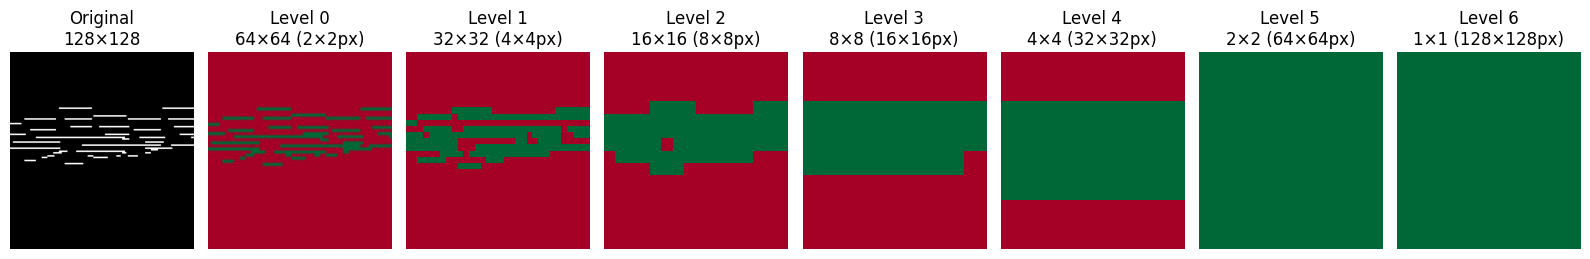

In [ ]:
#| eval: false
import matplotlib.pyplot as plt
import torch.nn.functional as F
from midi_rae.data import PRPairDataset

# Load one image from the dataset
ds = PRPairDataset(split='val')
img_tensor = ds[0]['img1'][:1]
x = img_tensor.unsqueeze(0)

# Run empty patch detection
enc = SwinEncoder(img_height=128, img_width=128)
non_empty = enc._compute_non_empty(x)
ne = non_empty[0].reshape(1, 1, 64, 64).float()

# Build hierarchy via max-pool cascade
levels = [ne[0, 0].cpu()]  # 64×64
while levels[-1].shape[0] > 1:
    ne = F.max_pool2d(ne, 2)
    levels.append(ne[0, 0].cpu())

# Plot: original image + all levels
fig, axes = plt.subplots(1, len(levels) + 1, figsize=(16, 2.7))
axes[0].imshow(img_tensor[0].cpu(), cmap='gray', origin='lower', aspect='auto')
axes[0].set_title('Original\n128×128')
for i, grid in enumerate(levels):
    g = grid.shape[0]
    axes[i+1].imshow(grid.numpy(), cmap='RdYlGn', origin='lower', aspect='auto', vmin=0, vmax=1)
    p = 128 // g
    axes[i+1].set_title(f'Level {i}\n{g}×{g} ({p}×{p}px)')
    axes[i+1].axis('off')
axes[0].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()